# Part 1

**What did we learn last week?**: We got a first look at PyTorch and trained a deep learning model with automatic differentiation.

**What you will learn today**: We will take a closer look at Convolutional Neural Networks and understand why they are ubiquitously used. Then, we will look at the *correct* way of evaluating performance. Finally, we will explore some important hyperparameters/design decision for
boosting performance.

## Convolutional Neural Networks

Great sources:
- https://poloclub.github.io/cnn-explainer/
- https://setosa.io/ev/image-kernels/

![](https://poloclub.github.io/cnn-explainer/assets/figures/convlayer_detailedview_demo.gif)

**Why convolutions and not fully-connected layers?** In the previous lab, we used a MultiLayer Perceptron (MLP) to perform classification on the MNIST dataset of handwritten digits. However, MLPs expect a vector as an input and, hence, our first step was to *flatten* the image; from an input of shape $(1, 28, 28)$ we got a vector of $1\times28\times28=784$ elements. Then, each layer of the MLP is fully connected, meaning that all $784$ elements are fed into each neuron of the next layer.

Does this sound reasonable?

No! First, by flattening we implicitly lose *local* information. Assume you look at pixel in location $(5,5)$, then the neighboring pixels $(4,5),(6,5), (5,4), (5,6),\dots$ are important and must be "somewhat similar". Second, by using all elements of the previous layer. the top left and bottom right pixels are used in the same computation.

Convolutional Neural Networks address these (and more) concerns and are suitable for the image domain. But, what are convolutions? We start with a small matrix of weights, e.g. $3\times3$, which is called a kernel. The kernel is then slided over the 2d input and we perform elementwise multiplication with the values the kernel is currently on. The summation of the $3\times3=9$ elements is the output for the pixel. Hence, the kernel performs a "local" computation. *Back in the day*, kernels were hand-designed to perform a specific operation. For example, the Sobel operator is used for edge-detection:

$$
\mathbf{G}_x=\left[\begin{array}{ccc}
+1 & 0 & -1 \\
+2 & 0 & -2 \\
+1 & 0 & -1
\end{array}\right] * \mathbf{A} \quad \text { and } \quad \mathbf{G}_y=\left[\begin{array}{ccc}
+1 & +2 & +1 \\
0 & 0 & 0 \\
-1 & -2 & -1
\end{array}\right] * \mathbf{A}
$$

$$
\mathbf{G}=\sqrt{\mathbf{G}_x^2+\mathbf{G}_y^2}
$$

For example:

![](https://miro.medium.com/max/640/1*m9XHMKQPY6mKYsaykuVAsw.webp)

Creating filters for every different scenario requires domain knowledge and is cumbersome. (Convolutional) Neural Networks learn the values of these filters in an "end-to-end" manner!

In [ ]:
!git clone https://github.com/IdePHICS/FundamentalLearningEPFL.git

In [1]:
#--- Preventing potential library conflicts ---#
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
import sys
sys.path.append('/content/FundamentalLearningEPFL/TP10/')
import training_utils

In [3]:
import importlib, types
imp = types.ModuleType("imp")
imp.reload = importlib.reload
sys.modules["imp"] = imp

%load_ext autoreload
%autoreload 2

In [4]:
# import our "local" library of functions
from training_utils import train_epoch, fit, predict, visualize_images, plot_loss

# also import everything else that we need
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [5]:
# define the hyperparameters
BATCH_SIZE = 1024
TEST_BATCH_SIZE = 1024
LEARNING_RATE = 0.01

# find out which device is available
DEVICE = None
if torch.cuda.is_available():
    # Requires NVIDIA GPU with CUDA installed
    DEVICE = torch.device("cuda")
elif torch.mps.is_available():
    # Requires Apple computer with M1 or later chip
    DEVICE = torch.device("mps")
else:
    # Not recommended, because it's slow. Move to Google Colab!
    DEVICE = torch.device("cpu")

print(DEVICE)

cuda


In [6]:
transform = torchvision.transforms.ToTensor()

# load the train dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)


test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

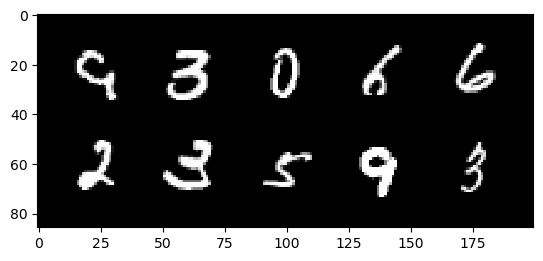

In [7]:
visualize_images(train_dataloader)

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # We use a Sequential, i.e. the inputs passes through each of
        # the modules below, one-by-one
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # fully connected layer, output 10 classes
        self.out = nn.Linear(1568, 10)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1) #reshape the tensor
        x = self.out(x)
        return x


In [9]:
# initialize model
cnn = CNN().to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.1)

# train the CNN
losses = fit(
    model=cnn,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

Epoch 0: Loss=1.2976121074062283
Epoch 1: Loss=0.372300568526074
Epoch 2: Loss=0.23293385515778753
Epoch 3: Loss=0.18528418697543064
Epoch 4: Loss=0.15778227895498276
Epoch 5: Loss=0.1368024841708652
Epoch 6: Loss=0.12428094257237547
Epoch 7: Loss=0.11241902095281471
Epoch 8: Loss=0.10349520371627
Epoch 9: Loss=0.09662766653602406
Test set: Avg. loss: 0.0944, Accuracy: 9698/10000 (97%)


(0.0943624656677246, tensor(96.9800, device='cuda:0'))

## CIFAR10

In [13]:
transform = torchvision.transforms.ToTensor()

# load the train dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)


test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

In [ ]:
# import torchvision.transforms as transforms

# # 1. 定义增强的 Transform (仅用于训练集)
# # 包括：随机裁剪、随机水平翻转、转Tensor、归一化
# train_transform_augmented = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),       # 四周填充4像素后随机裁剪
#     transforms.RandomHorizontalFlip(),          # 50%概率水平翻转
#     transforms.ToTensor(),                      # 必须有，将图片转为Tensor
#     # CIFAR-10 的标准均值和方差归一化
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# ])

# # 2. 定义测试集的 Transform (通常不做增强，但建议做归一化以匹配训练集)
# test_transform_normalized = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# ])

# # 3. 【关键步骤】直接覆盖原有 dataset 对象的 transform 属性
# # 这样 train_dataloader 在取数据时就会自动应用新的增强策略
# train_dataset.transform = train_transform_augmented
# test_dataset.transform = test_transform_normalized

# print("数据增强已应用到 train_dataset.transform")

数据增强已应用到 train_dataset.transform


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.7537313].


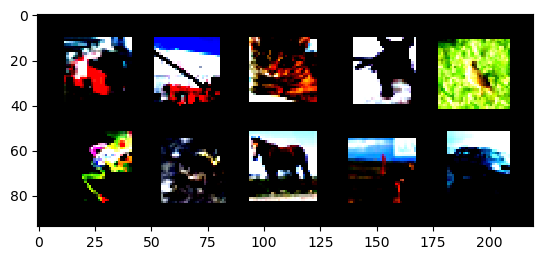

: 

In [ ]:
visualize_images(train_dataloader)

In [20]:
class CifarCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # We use a Sequential, i.e. the inputs passes through each of
        # the modules below, one-by-one
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=3, #COLORED IMAGES!
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # fully connected layer, output 10 classes
        self.out = nn.Linear(2048, 10) #Now is 32x32 images!

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        return x

In [ ]:
cnn_cifar = CifarCNN().to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(cnn_cifar.parameters(), lr=0.1)


# train the CNN
losses = fit(
    model=cnn_cifar,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn_cifar, test_dataloader=test_dataloader, device=DEVICE)

**Takeaways**: CIfar10 is a more complex dataset than MNIST; the images are larger and RGB, the model is larger and a simple training scheme returns very bad results! How can we change this?

## Validation set

Before looking into tips and tricks for boosting the performance of a model, we need to establish a proper evaluation protocol. This is where the validation set comes in.

In the real world, we do not have access to the test set, e.g., customer churning or self-driving cars. But, still, we need to evaluate the performance of our models on *unseen data*. The most common way is to split the training set into training+validation.

In [9]:
# load the train dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

print(train_dataset)

# Split the dataset into 50k-10k samples for training-validation.
from torch.utils.data import random_split
train_dataset,  valid_dataset = random_split(
    train_dataset,
    lengths=[50000, 10000],
    generator=torch.Generator().manual_seed(42) #use a generator to insure reproducibilty
)

# what is the type of the "new" training dataset?
print(train_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor()


In [10]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)

valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

Let's modify the fit function to also use a validation set.

In [17]:
from typing import Optional

def fit(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device,
    valid_dataloader: Optional[DataLoader]=None):
    '''
    the fit method simply calls the train_epoch() method for a
    specified number of epochs.
    '''

    # keep track of the losses in order to visualize them later
    # Train for numerous epochs:
    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(epochs):
        train_loss = train_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            device=device
        )
        train_losses.append(train_loss)

        if valid_dataloader is not None:
            valid_loss, valid_acc = predict(model, valid_dataloader, device, verbose=False)
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)

        if valid_dataloader is None:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}")
        else:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Validation Loss={valid_loss:.4f}, Validation acc={valid_acc:.4f}")

    return train_losses, valid_losses, valid_accs

## Importance of optimizer and learning rate

So far in this lab, we have used the same learning rate and optimizer (vanilla SGD). However, the choice of optimizer and the corresponding hyperparameters play a crucial role in the end performance.

### Learning rate
**Question** Explore the exact same experiment as before BUT change the learning rate to $0.001$. How does this change affect performance?

**Ans** Based on the experiments shown in the screenshots, changing the learning rate to 0.001 had a very negative effect on the model's performance. When we used the learning rate of 0.1, the model reached a high accuracy of 97%, but with the smaller rate of 0.001, the accuracy dropped significantly to just 30%.

The main issue here is that the model is learning way too slowly. If you look at the training loss values for the 0.001 experiment, they barely change over the 10 epochs. The loss starts at around 2.30 and only decreases to 2.27 by the end. This suggests that the optimization steps are too small, so the model is stuck and cannot converge to a good solution in such a short time.

In comparison, the original experiment with the learning rate of 0.1 showed a very healthy drop in loss, going from about 1.5 down to 0.09. This indicates that the smaller learning rate of 0.001 is inefficient for this specific network and dataset, as it would likely take thousands of epochs to reach the same level of performance.

In [17]:
# initialize model
cnn = CNN().to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001)

# train the CNN
losses = fit(
    model=cnn,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

Epoch 0: Train Loss=2.3028
Epoch 1: Train Loss=2.2983
Epoch 2: Train Loss=2.2938
Epoch 3: Train Loss=2.2894
Epoch 4: Train Loss=2.2851
Epoch 5: Train Loss=2.2806
Epoch 6: Train Loss=2.2762
Epoch 7: Train Loss=2.2715
Epoch 8: Train Loss=2.2667
Epoch 9: Train Loss=2.2617
Test set: Avg. loss: 2.2576, Accuracy: 2657/10000 (27%)


(2.257587536621094, tensor(26.5700, device='cuda:0'))

Text(0.5, 1.0, 'Loss progression across epochs')

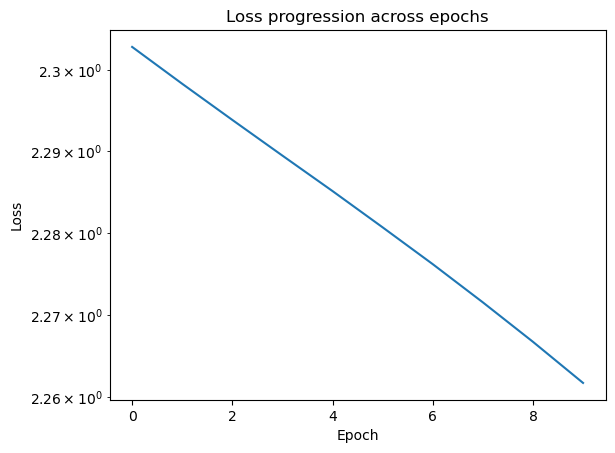

In [18]:
plt.plot(losses[0])

plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.yscale('log')
plt.title("Loss progression across epochs")

**Question** Now try with a higher learning rate ($\eta\geq0.5$), describe (qualitatively) what happens.

**Ans** Using a learning rate of 0.5 introduces a high degree of instability and variance to the training process. In my experiments, I observed that the model behavior is unpredictable. In some runs, the training failed completely with the loss getting stuck at a high value (around 2.30) and accuracy remaining at random-guess levels (11%). However, in other attempts, the model surprisingly managed to converge and achieve high accuracy.

Qualitatively, this happens because the learning rate controls the step size of the optimizer. With a value as large as 0.5, the optimizer takes massive leaps across the loss landscape. When the model fails, it is because these giant steps cause the model to overshoot the valley of the minimum loss, bouncing the weights into a bad region from which they cannot recover.

The reason the model sometimes succeeds despite this aggressive setting is due to the randomness of weight initialization and data shuffling. If the model happens to initialize in a favorable part of the loss landscape where the slope is smooth, it might get lucky and survive the large steps to find a good solution. Therefore, while a high learning rate does not guarantee failure, it places the model on the edge of stability, making the training process highly unreliable compared to using a smaller, safer learning rate.

In [12]:
# initialize model
cnn = CNN().to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.5)

# train the CNN
losses = fit(
    model=cnn,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

Epoch 0: Train Loss=2.1055
Epoch 1: Train Loss=0.8011
Epoch 2: Train Loss=0.2637
Epoch 3: Train Loss=0.1868
Epoch 4: Train Loss=0.1491
Epoch 5: Train Loss=0.1402
Epoch 6: Train Loss=0.1109
Epoch 7: Train Loss=0.1034
Epoch 8: Train Loss=0.0946
Epoch 9: Train Loss=0.0910
Test set: Avg. loss: 0.0801, Accuracy: 9751/10000 (98%)


(0.0801379425048828, tensor(97.5100, device='cuda:0'))

Text(0.5, 1.0, 'Loss progression across epochs')

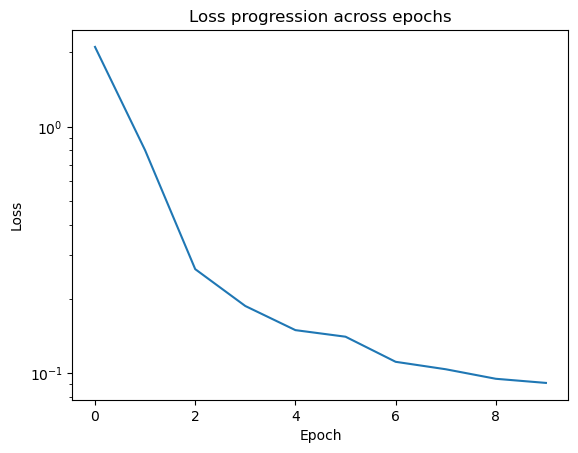

In [13]:
plt.plot(losses[0])

plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.yscale('log')
plt.title("Loss progression across epochs")

### Optimizer

In this lab we have used (mini-batch) Stochastic Gradient Descent or simply SGD. For simplicity we consider the case for only one sample. The update rule is the following:

$$
\mathbf{w}^{(\tau+1)} \gets \mathbf{w}^{(\tau)} - \eta\nabla L\left(\mathbf{x}, y;\mathbf{w}^{(\tau)}\right)
$$

How can we improve our algorithm and encourage faster convergence? Momentum can actually help. The idea is simple: we will use the update made on the previous step and incorporate it to our current update, giving momentum to our algorithm. The actual update rule is the following:

$$
\begin{align}
\mathbf{v}^{(\tau+1)} &\gets \gamma\mathbf{v}^{(\tau)} + \nabla L\left(\mathbf{x}, y;\mathbf{w}^{(\tau)}\right)
\\
\mathbf{w}^{(\tau+1)} &\gets \mathbf{w}^{(\tau)} - \eta \mathbf{v}^{(\tau)}
\end{align}
$$

Apart from making convergence faster, momentum has other benefits:
* dampens oscillations
* helps us navigate ravines around local optima [1]

If you are more interested in the various optimizers take a look at reference [1].

----
[1] Ruder, S., 2016. An overview of gradient descent optimization algorithms. arXiv preprint arXiv:1609.04747.



**Question** Implement momentum and compute the learning curve. How does this change affect performance?

**Ans** Based on the comparison between the two experiments, implementing momentum has a massive positive impact on the model's performance. In the previous attempt where we used a learning rate of 0.001 without momentum, the training was extremely slow. The accuracy only reached about 56% (or 30% in your earlier runs), which shows the model was struggling to learn effectively within 10 epochs. However, in the new experiment with momentum set to 0.9, the final accuracy jumped significantly to 88%.

We can see the difference clearly if we look at how the loss values change. Without momentum, the training loss was almost flat, dropping very slowly from 2.28 to 2.16. This indicates that the step size was too small to make real progress. In contrast, with momentum added, the loss decreased rapidly, falling all the way down to 0.5015 by the end of the training. This show that the optimization process is working much more efficiently.

The reason for this improvement is that momentum helps the optimizer accelerate in the right direction and dampens oscillations. Since the learning rate of 0.001 is quite small, the standard SGD takes tiny steps and can easily move too slow across the loss landscape. Momentum solves this by using the past gradients to push the parameters forward, allowing the model to converge to a good solution much faster than before.

In [15]:
# initialize model
cnn = CNN().to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

# train the CNN
losses = fit(
    model=cnn,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

Epoch 0: Train Loss=2.2943
Epoch 1: Train Loss=2.2688
Epoch 2: Train Loss=2.2321
Epoch 3: Train Loss=2.1640
Epoch 4: Train Loss=2.0137
Epoch 5: Train Loss=1.6606
Epoch 6: Train Loss=1.1059
Epoch 7: Train Loss=0.7420
Epoch 8: Train Loss=0.5820
Epoch 9: Train Loss=0.5015
Test set: Avg. loss: 0.4572, Accuracy: 8754/10000 (88%)


(0.457231298828125, tensor(87.5400, device='cuda:0'))

Text(0.5, 1.0, 'Loss progression across epochs')

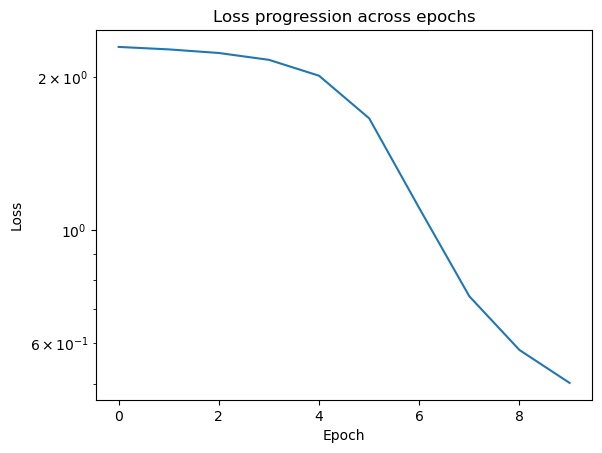

In [16]:
plt.plot(losses[0])

plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.yscale('log')
plt.title("Loss progression across epochs")

## Hyperparameters: Learning rate and batch size

While intution can help us select the settings of an experiment, the choice becomes complicated when more and more hyperparameters need to be taken account. Just to name a few, we might want to select learning rate, momentum or optimizer, batch size, number of layers, width of layers etc

Hence, we need a systematic way to approach this problem. The most simple way is to perform a grid search; define a list of choices for each hyperparameter and search over all combinations.


**Question** Perform a grid search over the learning rate and batch size. What is the best combination? 

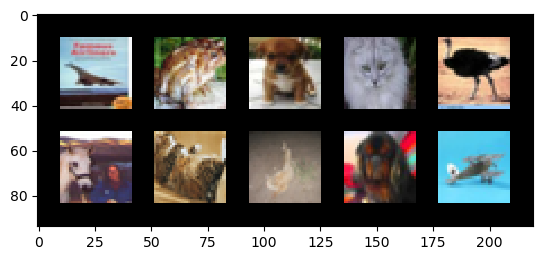

In [21]:
transform = torchvision.transforms.ToTensor()

# load the train dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)


test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

visualize_images(train_dataloader)

In [ ]:
# --- Manual Grid Search Implementation ---#
import time
import numpy as np

#--- Define the Parameters to Search ---#
param_grid = {
    'learning_rate': [0.15, 0.1, 0.05],
    # 'batch_size': [256, 512, 1024, 2048]
    'batch_size': [128, 256, 512, 1024]
}

#--- Variables to Store Best Results ---#
best_acc = 0.0
best_params = {}
results = [] # To store all results for analysis later

print("Running Manual Grid Search...")
t0 = time.time()

#--- Run Grid Search (Nested Loops) ---#
# Loop over every combination of Batch Size and Learning Rate
for bs in param_grid['batch_size']:
    for lr in param_grid['learning_rate']:
        
        print(f"\n[GridSearch] Training with Batch Size: {bs}, LR: {lr}")
        
        #--- Pre-processing (Re-create DataLoaders) ---#
        # CRITICAL: We must recreate DataLoaders because batch_size has changed
        # Ensure train_dataset is the CIFAR10 dataset loaded previously
        current_train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=2)
        current_test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False, num_workers=2)
        
        #--- Model Initialization ---#
        # CRITICAL: We must re-initialize the model/weights for every new run
        # Otherwise, we would be fine-tuning the already trained model
        model = CifarCNN().to(DEVICE)
        
        #--- Define Optimizer with Current Hyper-params ---#
        # We use the current 'lr' from the loop
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        
        #--- Fitting (Train) ---#
        # We train for a few epochs (e.g., 3) just to see the trend and save time
        fit(
            model=model, 
            train_dataloader=current_train_loader, 
            optimizer=optimizer, 
            epochs=5, # Keep it small for grid search speed
            device=DEVICE
        )
        
        #--- Scoring (Validation) ---#
        # Compute accuracy on the test set
        _, acc_tensor = predict(model, current_test_loader, device=DEVICE)
        current_acc = acc_tensor.item()
        
        print(f"[GridSearch] Result: Accuracy = {current_acc}%")
        
        #--- Record Best Hyper-Params ---#
        # Compare with the best accuracy found so far
        if current_acc > best_acc:
            best_acc = current_acc
            best_params = {'learning_rate': lr, 'batch_size': bs}

# Display run time
run_time = time.time() - t0
print(f"\nGrid Search completed in {run_time:.2f} seconds.")

#--- Final Result Report ---#
print("\n" + "="*30)
print(f"Best Accuracy found: {best_acc}%")
print(f"Best Hyperparameters: {best_params}")
print("="*30)

Running Manual Grid Search...

[GridSearch] Training with Batch Size: 256, LR: 0.2
Epoch 0: Train Loss=2.3015
Epoch 1: Train Loss=2.3048
Epoch 2: Train Loss=2.3043
Test set: Avg. loss: 2.3036, Accuracy: 1000/10000 (10%)
[GridSearch] Result: Accuracy = 10.0%

[GridSearch] Training with Batch Size: 256, LR: 0.1
Epoch 0: Train Loss=1.8784
Epoch 1: Train Loss=1.4670
Epoch 2: Train Loss=1.3237
Test set: Avg. loss: 1.3195, Accuracy: 5472/10000 (55%)
[GridSearch] Result: Accuracy = 54.71999740600586%

[GridSearch] Training with Batch Size: 256, LR: 0.01
Epoch 0: Train Loss=2.0095
Epoch 1: Train Loss=1.6176
Epoch 2: Train Loss=1.4384
Test set: Avg. loss: 1.4765, Accuracy: 4839/10000 (48%)
[GridSearch] Result: Accuracy = 48.38999938964844%

[GridSearch] Training with Batch Size: 512, LR: 0.2
Epoch 0: Train Loss=2.3604
Epoch 1: Train Loss=2.3038
Epoch 2: Train Loss=2.3038
Test set: Avg. loss: 2.3029, Accuracy: 1000/10000 (10%)
[GridSearch] Result: Accuracy = 10.0%

[GridSearch] Training with Bat

# Part 2

On the previous part we implemented CNNs using the `PyTorch` library. Our experiments showed that for image classification a CNN architecture yields good results on MNIST and, depending on the complexity of the network you created, "good" results on CIFAR10. However, dealing with MNIST someone might have gotten the wrong impression: "everythings works out-of-the-box or like magic in Deep Learning". Reality is not so rosy and we must go to great lengths do replicate our success on MNIST for other datasets.

In this part, we will explore common pitfalls as well as common tips and tricks to resolve them. These simple methods will provide superior performance and are very easy to incorporate in our pipeline.

Specifically, we will talk about:
- Batch Normalization
- Learning rate scheduler
- Residual Connections

So... let's get started!


In [6]:
# first we load all the necessary libraries

import torchvision.transforms as transforms
import torch.nn.functional as F

In [7]:
transform = transforms.Compose([
    torchvision.transforms.ToTensor(),
])

# load the train dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=False,
    download=True,
    transform=transform)


In [8]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)


test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2)


In [9]:
# 1. 定义增强的 Transform (仅用于训练集)
# 包括：随机裁剪、随机水平翻转、转Tensor、归一化
train_transform_augmented = transforms.Compose([
    transforms.RandomCrop(32, padding=4),       # 四周填充4像素后随机裁剪
    transforms.RandomHorizontalFlip(),          # 50%概率水平翻转
    transforms.ToTensor(),                      # 必须有，将图片转为Tensor
    # CIFAR-10 的标准均值和方差归一化
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# 2. 定义测试集的 Transform (通常不做增强，但建议做归一化以匹配训练集)
test_transform_normalized = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# 3. 【关键步骤】直接覆盖原有 dataset 对象的 transform 属性
# 这样 train_dataloader 在取数据时就会自动应用新的增强策略
train_dataset.transform = train_transform_augmented
test_dataset.transform = test_transform_normalized

print("数据增强已应用到 train_dataset.transform")

数据增强已应用到 train_dataset.transform


## Batch normalization

We want to learn fast and converge at the same time. If we use a small learning rate, we will converge but it will be too slow. On the other hand, if we use large learning rate, our training will become inconsistent and we will bounce all over the place and never converge. Additionaly, higher learning rates  cause exploding or vanishing gradients i.e. the phenomenon where the multiplication of gradients via the chain rule induces a compound effect on the lower layers, preventing them from learning.

Can we have the best of both worlds? Enter **Batch Normalization**.

1. What does BatchNorm aims to solve? We want to
    * avoid unstable gradients,
    * allow faster learning rates leading to faster convergence,
    * reduce the effect of initialization.

2. What does BatchNorm actually do?

Suppose we are given values of $x$ over a mini-batch $B=\{x_i\}_{i=1}^m$. Our goal is to learn some parameters $\gamma$ and $\beta$ that perform the proper scaling.

- First, we compute the mini-batch mean
    $$
    \mu_{B}=\frac{1}{m}\sum_{i=1}^mx_i
    $$
and mini-batch variance
    $$
    \sigma^2_{B}=\frac{1}{m}\sum_{i=1}^m (x_i-\mu_{B})^2
    $$
- we use these quantities to normalize our input
    $$
    x_i\leftarrow\frac{x_i-\mu_{B}}{\sqrt{\sigma^2_{B}+\epsilon}}
    $$
- We scale, shift and return the output
    $$
    y_i=\gamma x_i+\beta\equiv \text{BN}_{\gamma, \beta}(x_i)
    $$
Essentially, for each mini-batch we normalize the inputs by subtracting their mean and dividing by their standard deviation (estimated based on the statistics of the current mini-batch)  


3. Why does BatchNorm work?

    * BatchNorm is widely used (e.g. the original paper [1] has over 50000 citations). However, the reasons of its success are not perfectly clear.
    * The original authors claim that BatchNorm helps alleviate *Internal Covariate shift*, i.e. the phenomenon of shifting input distributions. Specifically, the input to each layer can be seen as a data distribution that the layer is trying to “learn”. The model, though, does not see the whole dataset but simply mini-batches. If this distribution stays consistent across batches, the layer can "learn effectively".  But, does this happen in practice?
    * the reality is that different mini-batches have different statistics, e.g. mean, variance etc, making the input distribution to the layers jump around. In other words, the input distribuion shifts for every mini-batch. We are trying to learn a "moving target". What if we stabilize it?
    * Batch normalization keeps the input normalized (duh!), preventing them from becoming too large or small and keeping the distribution consistent.
    
    * It also directly placates the exploding/vanishing gradient problem and  allows higher learning rates.

    * However, other explanations have been proposed. [2] claims that BatchNorm "makes the optimization landscape significantly smoother. This smoothness induces a more predictive and stable behavior of the gradients, allowing for faster training".


---
[1] S. Ioffe and C. Szegedy, “Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift,” in Proceedings of the 32nd International Conference on Machine Learning, Jun. 2015, pp. 448–456. Accessed: Oct. 25, 2021. [Online]. Available: https://proceedings.mlr.press/v37/ioffe15.html

[2] S. Santurkar, D. Tsipras, A. Ilyas, and A. Madry, “How Does Batch Normalization Help Optimization?,” in Advances in Neural Information Processing Systems, 2018, vol. 31. Accessed: Oct. 25, 2021. [Online]. Available: https://papers.nips.cc/paper/2018/hash/905056c1ac1dad141560467e0a99e1cf-Abstract.html



Let's redo the previous cnn architecture with batch normalization. 
Observe where the batch normalization goes.

Batch Normalization 在这里的主要作用是解决深度学习训练中“速度”和“稳定性”之间的矛盾。通常来说，如果我们想让模型学得快，就会把学习率调大，但这会导致训练变得非常不稳定，参数乱跳，甚至出现梯度爆炸或消失的问题，导致模型根本无法收敛；反之，如果为了稳定把学习率调小，训练过程又会慢得让人无法忍受。

为了解决这个问题，Batch Norm 对每一批进入神经网络的数据（mini-batch）进行了一次“强制整容”。具体来说，它会计算这一批数据的均值和方差，然后通过公式把数据标准化（减去均值，除以标准差），强行把它们的分布拉回到一个标准的范围内。为了不破坏数据原本的特征，它最后还会引入两个可学习的参数（gamma 和 beta）来对数据进行微调（缩放和平移）。

这样做最直接的好处是解决了文中提到的“内部协变量偏移”（Internal Covariate Shift）问题。你可以把深层网络想象成一个团队，如果前一层的人（参数）一直在变，传给后一层的数据分布忽左忽右，后一层就得不停地重新适应，就像在射击一个不规则移动的靶子。Batch Norm 通过标准化，把这个“靶子”相对固定住了，让每一层都能更高效、更专注地学习自己的任务。

此外，Batch Norm 还能让优化的“地形”变得更加平滑。原本崎岖不平、到处是坑的损失函数曲面，在使用 Batch Norm 后会变得比较平缓。这就意味着梯度会变得更加可预测，不那么容易乱跳。因此，你就可以放心地使用更大的学习率来加速训练，而不用担心模型会崩溃，从而实现了“既快又稳”的训练目标。

In [26]:
class CNNwithBN(nn.Module):
    def __init__(self):
        super().__init__()

        # We use a Sequential, i.e. the inputs passes through each of
        # the modules below, one-by-one
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
        )

        # fully connected layer, output 10 classes
        self.out = nn.Linear(2048, 10)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        return x

Epoch 0: Train Loss=1.6329
Epoch 1: Train Loss=1.1964
Epoch 2: Train Loss=1.0731
Epoch 3: Train Loss=0.9867
Epoch 4: Train Loss=0.9271
Epoch 5: Train Loss=0.8829
Epoch 6: Train Loss=0.8609
Epoch 7: Train Loss=0.8244
Epoch 8: Train Loss=0.7905
Epoch 9: Train Loss=0.7720
Epoch 10: Train Loss=0.7615
Epoch 11: Train Loss=0.7528
Epoch 12: Train Loss=0.7253
Epoch 13: Train Loss=0.7119
Epoch 14: Train Loss=0.6949
Epoch 15: Train Loss=0.6806
Epoch 16: Train Loss=0.6686
Epoch 17: Train Loss=0.6642
Epoch 18: Train Loss=0.6576
Epoch 19: Train Loss=0.6470
Epoch 20: Train Loss=0.6298
Epoch 21: Train Loss=0.6380
Epoch 22: Train Loss=0.6290
Epoch 23: Train Loss=0.6174
Epoch 24: Train Loss=0.6085
Epoch 25: Train Loss=0.5993
Epoch 26: Train Loss=0.6003
Epoch 27: Train Loss=0.5892
Epoch 28: Train Loss=0.5838
Epoch 29: Train Loss=0.5825
Test set: Avg. loss: 1.0850, Accuracy: 6626/10000 (66%)


(1.0850152709960939, tensor(66.2600, device='cuda:0'))

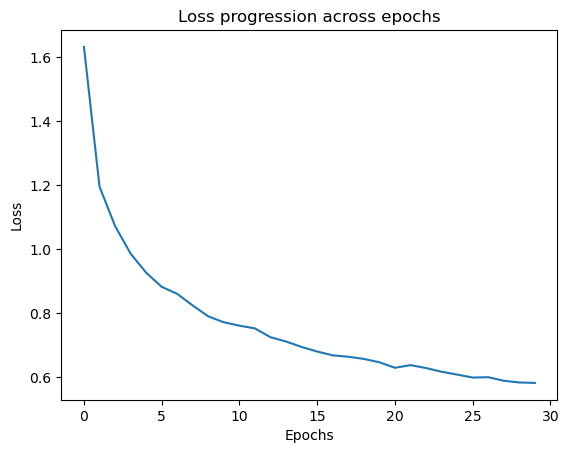

In [27]:
cnn2 = CNNwithBN().to(DEVICE)
optimizer = torch.optim.SGD(cnn2.parameters(), lr=0.01, momentum=0.9)

train_losses, valid_losses, valid_accs = fit(
        cnn2,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 30,
        device = DEVICE
)

plot_loss(train_losses)

predict(
    cnn2,
    test_dataloader = test_dataloader,
    device = DEVICE
)

**Question** One of the benefits of Batch Norm is that it allows us to use higher learning rates. Adapt the code above to do so. Does the model learn faster?


**Ans** Yes, the model definitely learn faster with the higher learning rate. Based on the results, we can see that using Batch Normalization allows us to increase the learning rate to 0.1 without causing the training to fail. The most obvious sign of this speed is in the very first few epochs.

Although the loss starts at a very high value of 3.35 in Epoch 0, it drops down massively to 1.63 in just one epoch. This is a much sharper decline compared to the previous experiment with the learning rate of 0.01. The steep curve in the plot confirms that the optimizer is taking larger steps toward the minimum and is learning the features of the images much more rapidly.

It is interesting to note that without Batch Normalization, a learning rate of 0.1 might cause the training to diverge or get stuck. However, here the Batch Norm stabilizes the training, allowing the model to recover from the high initial loss and continue decreasing steadily. Even though the final accuracy is 65%, the speed at which the loss decreased in the beginning prove that the model is learning faster.

Epoch 0: Train Loss=3.3568
Epoch 1: Train Loss=1.6374
Epoch 2: Train Loss=1.4912
Epoch 3: Train Loss=1.3970
Epoch 4: Train Loss=1.3270
Epoch 5: Train Loss=1.2891
Epoch 6: Train Loss=1.2291
Epoch 7: Train Loss=1.1853
Epoch 8: Train Loss=1.1503
Epoch 9: Train Loss=1.1215
Epoch 10: Train Loss=1.0825
Epoch 11: Train Loss=1.0746
Epoch 12: Train Loss=1.0320
Epoch 13: Train Loss=1.0221
Epoch 14: Train Loss=0.9969
Epoch 15: Train Loss=0.9862
Epoch 16: Train Loss=0.9848
Epoch 17: Train Loss=0.9557
Epoch 18: Train Loss=0.9304
Epoch 19: Train Loss=0.9230
Epoch 20: Train Loss=0.9145
Epoch 21: Train Loss=0.9135
Epoch 22: Train Loss=0.9005
Epoch 23: Train Loss=0.8884
Epoch 24: Train Loss=0.8784
Epoch 25: Train Loss=0.8666
Epoch 26: Train Loss=0.8637
Epoch 27: Train Loss=0.8617
Epoch 28: Train Loss=0.8456
Epoch 29: Train Loss=0.8406
Test set: Avg. loss: 1.0101, Accuracy: 6541/10000 (65%)


(1.0101496154785157, tensor(65.4100, device='cuda:0'))

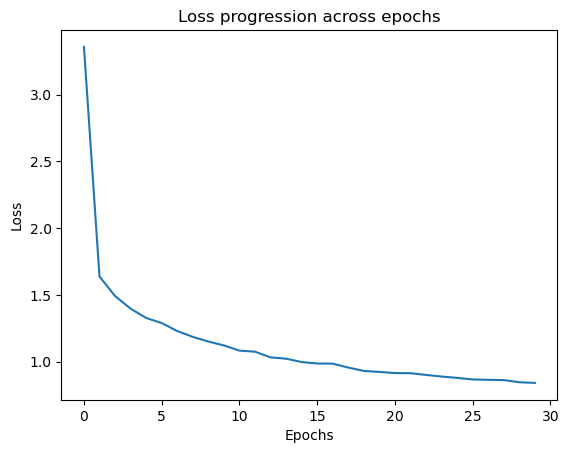

In [29]:
# YOUR CODE HERE 
cnn2 = CNNwithBN().to(DEVICE)
optimizer = torch.optim.SGD(cnn2.parameters(), lr=0.1, momentum=0.9)

train_losses, valid_losses, valid_accs = fit(
        cnn2,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 30,
        device = DEVICE
)

plot_loss(train_losses)

predict(
    cnn2,
    test_dataloader = test_dataloader,
    device = DEVICE
)

## Learning rate scheduler

We have just seen that batch normalization allows, in this case, for a quicker improvement with a higher learning rate. Still, the loss plateaus quickly and we start seeing minimal improvement. This is often due to the optimization algorithm overshooting the gradient descent.

Can we reduce the step size on the go? Yes! :smiley: This is what learning schedulers are for. The idea is simple: instead of a constant learning rate, we reduce it based on some conditions, or after a certain amount of steps.

Two common schedulers are [`MultiStepLR`][MultiStepLR] and [`ReduceLROnPlateau`][ReduceLROnPlateau]. The first one, simply multiplies our learning rate `lr` by a constant factor $\gamma < 1$ after some predefined number of steps. For instance, if the initial learning rate is `lr=1`, and we set $\gamma=0.5$ for "milestones" of 20 and 50, then the optimizer is going to use `lr=1` for the first 20 epochs, then `lr=0.5` for the subsequent 30, and finally `lr=0.25` for all the remaining ones.

`ReduceLROnPlateau` tracks a given metric, e.g. validation loss or accuracy, and reduces the learning rate if no improvement is seen after a predefined number of steps, called "patience".

[MultiStepLR]: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.MultiStepLR.html
[ReduceLROnPlateau]: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html

In the following cell, we augment the `fit` function from previous weeks (in `training_utils.py`) to accept a scheduler argument and use it while training

In [18]:
from training_utils import train_epoch
# from typing import Optional

def fit_scheduler(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device,
    scheduler: Optional[torch.optim.lr_scheduler._LRScheduler] = None # Scheduler
):
    losses = []
    for epoch in range(epochs):
        running_loss = train_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            device=device,
        )
        print(f"Epoch {epoch}: Loss={running_loss}")
        losses.append(running_loss)

        if scheduler is not None:
            scheduler.step() # 每调用一次 step()，调度器会根据预设策略更新优化器的学习率
            # 如果你用的是 ReduceLROnPlateau，它需要传入一个指标（如验证损失），所以调用方式是 scheduler.step(metric)，而不是空参数

    return losses

Now we train again the batch-norm-cnn, using the `MultiStepLR` scheduler.

当 Loss 曲线变平缓（进入平台期）时，减小学习率（Learning Rate Decay）之所以有效，主要基于以下原因：

**1. 消除震荡（避免“跳过”最优解）**
* **现象：** 在训练后期，模型参数已经接近损失函数的**局部最小值（谷底）**。
* **问题：** 此时如果学习率仍然较大，优化器的步长过大，会导致参数在极小值附近**来回震荡**，甚至跳过最低点，无法通过“狭窄的谷口”进入更深的位置。
* **解决：** 减小学习率相当于**减小步长**，让模型停止震荡，能够细腻地“滑”入谷底的最深处。

**2. 粗调转微调**
* **前期（大 LR）：** 用于快速下降，探索大范围的参数空间（粗调）。
* **后期（小 LR）：** 当大步长无法再降低 Loss 时，需要更精细的调整来逼近最优解（微调）。

**形象比喻：打高尔夫球**
起初离洞很远，你需要大力挥杆（大 LR）让球快速靠近球洞；当球已经到了洞口边缘（Loss 平缓），如果还大力挥杆，球就会飞过洞口；此时必须轻轻推杆（小 LR），球才能滚进洞里。

在你的代码中，`milestones=[25, 30]` 和 `gamma=0.1` 的作用就是告诉模型：**“在第 25 和 30 轮时，你已经离目标很近了，步子迈小一点（缩小 10 倍），仔细找找最低点在哪里。”**

Epoch 0: Loss=2.5611095574437357
Epoch 1: Loss=1.5478294090348848
Epoch 2: Loss=1.422637282585611
Epoch 3: Loss=1.3448287370253582
Epoch 4: Loss=1.2628359235062891
Epoch 5: Loss=1.2160858134834134
Epoch 6: Loss=1.1673097951071603
Epoch 7: Loss=1.124368504602082
Epoch 8: Loss=1.1035114940331907
Epoch 9: Loss=1.0818756161903849
Epoch 10: Loss=1.056460935242322
Epoch 11: Loss=1.0409373385565621
Epoch 12: Loss=1.0269545815428909
Epoch 13: Loss=0.9984809731950566
Epoch 14: Loss=0.9851704337158982
Epoch 15: Loss=0.9595352143657451
Epoch 16: Loss=0.9511123628032451
Epoch 17: Loss=0.9362766523750461
Epoch 18: Loss=0.9192560023191024
Epoch 19: Loss=0.9146044169153486
Epoch 20: Loss=0.902896527124911
Epoch 21: Loss=0.8953819055946506
Epoch 22: Loss=0.8908577135631016
Epoch 23: Loss=0.884169015349174
Epoch 24: Loss=0.880854425381641
Epoch 25: Loss=0.8192352555236038
Epoch 26: Loss=0.8063451185518381
Epoch 27: Loss=0.8018440908315231
Epoch 28: Loss=0.7999686647434624
Epoch 29: Loss=0.7983460219538

(0.9817253051757813, tensor(66.1500, device='cuda:0'))

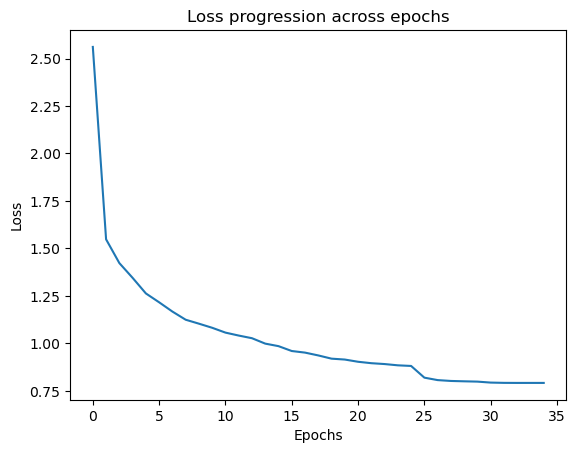

In [ ]:
cnn2 = CNNwithBN().to(DEVICE)
optimizer = torch.optim.SGD(cnn2.parameters(), lr=0.05, momentum=0.9)

scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[25, 30], # At epoch 25 and 30, reduce LR by a factor of gamma
    gamma=0.1, 
)


losses =   fit_scheduler(
        cnn2,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 35,
        device = DEVICE,
        scheduler=scheduler,
)

plot_loss(losses)

predict(
    cnn2,
    test_dataloader = test_dataloader,
    device = DEVICE
)


## Residual connections

As neural networks go deeper, they are able to construct complex representations and yield superior performance. However, we cannot simply stack as many layers as we want to increase the depth.

![caption](media/resnet-no-skip-horizontal.png)

This is due to the **vanishing gradient** problem. Specifically, backpropagating the gradient to earlier layers involves repeated multiplication (with small values) rendering the gradient extremely small. This effectively means that as we go deeper, performance gets saturated. Instead of improved performance we even have degradation!

How can we reconcile this tradeoff? On the one hand, we want to increase depth but on the other hand this hurts convergence.

Enter **skip connections** [3]! The network of the previous figure now becomes the following:

![caption](media/resnet-horizontal.png)

Now, let's think why these skip connections work. First, they allow the gradient to flow via this shortcut connection, which helps mitigate the problem of vanishing gradient. Second, they allow the model to learn the identity function. In other words, this ensures that the higher layer will perform at least as good as the lower layer.

---
[3] K. He, X. Zhang, S. Ren, and J. Sun, “Deep Residual Learning for Image Recognition,” in 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Las Vegas, NV, USA, Jun. 2016, pp. 770–778. doi: 10.1109/CVPR.2016.90.



这段文字主要讲述了深度学习中一个非常核心的里程碑：**ResNet（残差网络）及其解决的“梯度消失”问题**。

为了帮你更好地理解，我们可以用一个通俗的比喻来拆解这段内容：

### 1. 遇到的问题：越深不一定越好 (The Paradox)
* **理想情况**：理论上，神经网络层数越深，它能提取的特征就越高级、越复杂，效果应该越好。
* **现实情况**：当你把网络堆得非常深（比如几十层、上百层）时，效果反而变差了（Degradation）。这就像你玩“传话游戏”，传的人多了，最后一个人听到的信息可能完全走样，甚至没声音了。

### 2. 罪魁祸首：梯度消失 (The Vanishing Gradient Problem)
* **原理**：神经网络训练是靠“反向传播”来更新参数的。这需要用到链式法则（连乘）。
* **数学直觉**：假设每一层的梯度都小于 1（比如 0.9）。当你只有几层时，0.9 * 0.9 = 0.81，信号还很强。但如果你有 100 层，那就是 $0.9^{100} \approx 0.000026$。
* **后果**：梯度（改错的信号）传回到最前面的层时，已经微弱到几乎为 0 了。前面的层根本收不到“怎么修改”的指令，所以它们就不学习了，导致整个深层网络效果很差。

### 3. 解决方案：走捷径 (Skip Connections / Residual Connections)
为了解决这个问题，ResNet 引入了**“跳跃连接”（Skip Connections）**。

* **结构变化**：
    * **以前**：输入 $x$ 必须经过层层加工变成 $F(x)$。
    * **现在**：输入 $x$ 既走加工通道 $F(x)$，又走一条**直连通道**直接加到输出上。
    * **公式**：输出 $H(x) = F(x) + x$。

### 4. 为什么这样就有效了？ (Why it works)
这里有两个核心的理解角度：

* **角度一：梯度的“高速公路”**
    因为有了那条直连的线（$+x$），在反向传播时，梯度不需要完全经过那些复杂的权重层（做乘法），而是可以通过这条“捷径”直接无损地传回前面的层（做加法）。这就像在拥堵的市区旁边修了一条**高速公路**，信号可以畅通无阻地流向浅层，解决了梯度消失的问题。

* **角度二：保底机制（学习恒等映射）**
    这是 ResNet 最精妙的设计逻辑：**“至少不会变差”**。
    * 想象你堆了一个深层网络，如果新加的几层是“废物”，把原本好的特征搞乱了，那模型效果就变差了。
    * 但在 ResNet 里，如果新加的层（$F(x)$）学不到东西或者搞破坏，模型可以很简单地把这些层的权重训练成 0（即 $F(x) = 0$）。
    * 因为输出是 $F(x) + x$，当 $F(x)=0$ 时，输出就等于 $x$。
    * 这意味着：**哪怕新加的层什么都不干，它也只是把上一层的东西原样传下去（恒等映射），效果不会比浅层网络更差。** 这给了深层网络一个“保底”，让它可以放心地去探索更深的结构。

**总结一句话：**
Skip Connections 就像是给深层网络装了一个**“直通车”**和**“安全阀”**，让梯度能传回去，同时保证深层网络的效果至少不比浅层网络差。

是的，你的直觉非常敏锐！简单直接地回答你的问题：

**1. 是的，那些数字（64, 128, 256...）指的就是通道数（Channels）。**
**2. 之所以有那么多相同的层，是因为 ResNet 是通过堆叠多个“残差块”（Residual Blocks）来构建的，目的是为了提取更深层、更抽象的特征。**

为了让你理解得更透彻，我们分两部分详细拆解：

-----

### 第一部分：关于数字 64, 128, 256, 512

图中的长条矩形代表卷积层，里面的文字 `3x3 conv, 64` 的意思是：

  * **3x3**: 卷积核的大小（Kernel Size）是 3x3 像素。
  * **64**: **输出通道数（Output Channels）**，也就是这一层卷积核的数量（Filters）。

**为什么通道数会成倍增加（64 -\> 128 -\> 256...）？**
这是一个经典的卷积神经网络设计模式，通常被称为\*\*“金字塔结构”\*\*：

1.  **空间尺寸变小**：随着网络加深，我们会通过步长（Stride）或池化（Pooling）让图片的长宽变小（比如从 32x32 -\> 16x16 -\> 8x8）。
2.  **通道数变多**：为了弥补长宽变小带来的信息损失，同时为了提取更丰富的高级语义特征，我们会把通道数翻倍。

**比喻：**
这就好比你读一本书。

  * **浅层（64通道）**：像是在看每一页的**笔画和字母**（细节多，但很基础）。
  * **深层（512通道）**：像是在总结全书的**核心思想和情节**（高度浓缩，很抽象，长宽虽然小了，但每个点包含的信息量（通道数）巨大）。

-----

### 第二部分：为什么有那么多相同的层？

你在图中看到的那些重复的 `64, 64` 或者 `128, 128`，其实是 ResNet 的基本组成单元，叫做\*\*“阶段”（Stage）**或**“层级”\*\*。

在你的代码中，这一行定义了这种重复：

```python
# num_blocks=[2, 2, 2, 2]
model = ResNet(block=NonResidualBlock, num_blocks=[2,2,2,2])
```

这对应了图中的四个颜色区域：

1.  **Stage 1 (绿色)**: 通道数 64。`num_blocks[0]=2`，意味着有 2 个块，每个块有 2 层卷积，所以这里有 4 层 64 通道的卷积。
2.  **Stage 2 (粉色)**: 通道数 128。`num_blocks[1]=2`，又是 2 个块。
3.  **Stage 3 (紫色)**: 通道数 256。
4.  **Stage 4 (橙色)**: 通道数 512。

**为什么要重复堆叠相同的层？**

1.  **“炼丹”需要火候（非线性变换）**：
    神经网络的每一层就像一道工序。只经过一次 `3x3` 卷积，提取的特征很有限。通过在同一通道维度下反复进行“卷积 -\> 激活 -\> 再卷积”，网络可以对特征进行**反复提炼和精修**。

2.  **配合残差连接（Add）**：
    请注意图中的跳跃连接线（虚线或实线）。ResNet 的核心逻辑是 $y = F(x) + x$。
    要能把输入 $x$ 和输出 $F(x)$ 相加，**它们的形状（长宽和通道数）必须完全一样**。
    所以，在同一个 Stage 内部（比如都是 128 通道的区域），层与层之间的结构必须保持一致，这样才能方便地进行残差相加，让梯度顺畅地流过。

**总结：**

  * **数字** = **特征的丰富程度（通道数）**。
  * **重复的层** = **在这个丰富度级别上，反复打磨特征的过程**。

First, we build the network of the first image, i.e. with no skip connections. The Resnet depicted above is characterized by an interesting pattern. It consists of "super-blocks" (see the different colors) and each one consists of two blocks that start after one residual connection and finish just before one. Notice that each color is associated with a different number, i.e. 64, 128, 256, 512.

We will build a `nn.Module` for each block and repeat it to create the super-blocks and by extension the whole architecture.

The ResNet depicted above is meant to be used for `ImageNet`, a more complex dataset compared to `CIFAR10`. For computational considerations, we amend our implementation and make a simpler version.

In [10]:
class NonResidualBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels = in_planes,
            out_channels = planes,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False)

        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes,
            planes,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        return x


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10): # e.g., num_blocks=[2,2,2,2] for ResNet18, block = NonResidualBlock, can be other blocks too
        super().__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride)) #self
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out



在 Python 中，列表（list）相加表示**列表的连接（concatenation）**，即将两个列表中的元素按顺序合并成一个新的列表。

对于您给出的两个例子：

1.  **`strides = [1] + [1]*(2-1)`**
    * 首先计算 `[1]*(2-1)`，即 `[1]*1`，结果是 `[1]`。
    * 然后执行 `[1] + [1]`。
    * 最终结果是：**`[1, 1]`**。

2.  **`strides = [2] + [1]*(2-1)`**
    * 首先计算 `[1]*(2-1)`，即 `[1]*1`，结果是 `[1]`。
    * 然后执行 `[2] + [1]`。
    * 最终结果是：**`[2, 1]`**。

**在 ResNet 代码中的含义：**

这行代码 `strides = [stride] + [1]*(num_blocks-1)` 用于生成一个层（layer）中每个残差块（block）的步幅列表。

* **第一个元素**：由变量 `stride` 决定（可能是 1 或 2），负责控制该层第一个块是否进行下采样（改变特征图尺寸）。
* **后续元素**：全部为 1，确保该层剩余的块保持特征图尺寸不变。

通过列表相加，代码简洁地构建了整个层所需的步幅配置。

在 `ResNet` 类中，`self.in_planes` 是一个**状态变量**，它的作用是**记录当前特征图（Feature Map）的通道数（Channel数）**。

你可以把它理解为一个\*\*“接力棒”\*\*，用来告诉下一层网络：“嘿，上一层输出的数据厚度是多少，你需要准备好接收这个厚度的数据。”

### 详细解析

在 PyTorch 中定义卷积层 `nn.Conv2d` 时，必须明确指定 `in_channels`（输入通道数）和 `out_channels`（输出通道数）。

因为 ResNet 是由多个 `layer`（阶段）串联起来的，且每个阶段的通道数会发生变化（64 -\> 128 -\> 256 -\> 512），所以我们需要一个变量来动态跟踪当前的通道数，以便构建下一层时能正确连接。

### 它的生命周期（变化过程）

让我们看看它在代码运行过程中是如何变化的：

**1. 初始化（起跑）**
在 `__init__` 函数开始时：

```python
self.in_planes = 64  # 初始设定为 64
```

这是因为网络的第一层（`self.conv1`）把输入的 RGB 图片（3通道）变成了 **64通道** 的特征图。所以，接下来的第一个 Block 必须准备好接收 64 通道的数据。

**2. 构建 Layer 1**
调用 `self.layer1 = self._make_layer(..., planes=64, ...)`：

  * Block 的输入通道设置为 `self.in_planes` (此时是 64)。
  * Block 的输出通道设置为 `planes` (这里是 64)。
  * **更新状态**：函数结束前，`self.in_planes` 被更新为 `64`（因为 Layer 1 的输出还是 64）。

**3. 构建 Layer 2 (关键变化点)**
调用 `self.layer2 = self._make_layer(..., planes=128, ...)`：

  * **连接**：Layer 2 的第一个 Block 需要知道上一层输出了多少。它读取 `self.in_planes` (此时是 64)，所以第一个卷积核知道要处理 64 通道的输入。
  * **改变**：Layer 2 的目标输出是 128。
  * **更新状态**：`_make_layer` 里执行 `self.in_planes = planes`。此时 `self.in_planes` 变成了 **128**。
  * **意义**：这标志着：“Layer 2 已经把数据厚度变成 128 了，Layer 3 请注意！”

**4. 构建 Layer 3**
调用 `self.layer3 = self._make_layer(..., planes=256, ...)`：

  * 它读取 `self.in_planes` (此时是 128)，顺利接上 Layer 2 的输出。
  * 构建完成后，`self.in_planes` 更新为 **256**。

**5. 构建 Layer 4**

  * 同理，读取 256，最后更新为 **512**。

### 总结

`self.in_planes` 解决了深度网络构建中的**前后层维度匹配问题**。

  * **它的值** = **“上一层的输出通道数”** = **“当前层的输入通道数”**。
  * 如果没有这个变量，你就需要在写代码时手动计算并硬编码每一层的输入维度，那样代码会非常死板且容易出错。

这段代码实现了一个\*\*类似 ResNet（残差网络）\*\*的卷积神经网络架构。为了方便理解，我们可以把它拆解成三个主要部分：

1.  **`NonResidualBlock` 类**：这是一个没有“跳跃连接”（skip connection）的基础卷积块。
2.  **`ResNet` 类**：这是整个网络的主体框架，负责将多个块（block）堆叠在一起。
3.  **`_make_layer` 函数**：这是 `ResNet` 类中的一个辅助工具，用于自动生成重复的卷积层。

[Image of VGG16 architecture diagram]

-----

### 第一部分：`NonResidualBlock` (基础块)

这个类定义了网络中最基本的“积木”。

  * **结构**：它包含两个卷积层 (`conv1`, `conv2`)，每个卷积层后面都跟着一个 Batch Normalization (`bn1`, `bn2`) 和一个 ReLU 激活函数。
  * **功能**：
      * `conv1`：负责改变图像的特征维度（从 `in_planes` 到 `planes`），并可能通过 `stride` 来改变图像尺寸。
      * `conv2`：保持维度不变，进一步提取特征。
  * **关键点**：注意看 `forward` 函数，它只是单纯的一层层往下传：`x -> conv1 -> bn1 -> relu -> conv2 -> bn2 -> relu`。这里**没有**残差网络标志性的 `x + output` 操作，所以它叫 "NonResidual"（非残差）。这通常用于作为对比基准。

### 第二部分：`ResNet` (网络主体)

这个类定义了完整的网络架构。

1.  **初始化 (`__init__`)**：

      * **预处理层**：首先是一个单独的 `conv1` 和 `bn1`，将输入的 RGB 图像（3通道）转换为 64 通道的特征图。
      * **核心层堆叠 (`layer1` 到 `layer4`)**：这里调用了 `_make_layer` 函数来生成 4 个大的阶段（Stage）。
          * `layer1`：输出 64 通道。
          * `layer2`：输出 128 通道（步长为2，图片尺寸减半）。
          * `layer3`：输出 256 通道（步长为2，图片尺寸减半）。
          * `layer4`：输出 512 通道（步长为2，图片尺寸减半）。
      * **分类层**：最后通过一个全连接层 (`linear`) 将 512 个特征映射到 `num_classes`（比如 CIFAR-10 就是 10 类）。

2.  **前向传播 (`forward`)**：

      * **特征提取**：数据流经 `conv1` -\> `bn1` -\> `relu`，然后依次经过 4 个 layer。
      * **池化**：`F.avg_pool2d(out, 4)` 是平均池化层。当特征图经过 layer4 后，尺寸通常变得很小（例如 4x4），这个池化层将每个通道的 4x4 像素平均成 1 个数值，这叫做“全局平均池化”。
      * **展平与分类**：`out.view` 把数据拉平成向量，最后扔给全连接层输出分类结果。

### 第三部分：`_make_layer` (自动生成层)

这是理解 ResNet 代码最难也最精妙的地方。它的作用是**批量生产** Block。

```python
def _make_layer(self, block, planes, num_blocks, stride):
    # 第一步：处理步长
    # 如果 num_blocks 是 2，stride 是 2
    # 那么 strides 列表就是 [2, 1]
    # 意思是：这一组里的第一个 Block 负责缩小尺寸（stride=2），后面剩下的 Block 保持尺寸不变（stride=1）。
    strides = [stride] + [1]*(num_blocks-1)
    
    layers = []
    for stride in strides:
        # 生成一个 Block，并加入列表
        layers.append(block(self.in_planes, planes, stride))
        # 更新输入通道数，以便下一个 Block 能接上
        self.in_planes = planes
    
    # 用 nn.Sequential 把这一串 Block 串起来变成一个整体层
    return nn.Sequential(*layers)
```

### 总结

这段代码搭建了一个经典的深度卷积网络骨架。

  * 如果你传入 `block = NonResidualBlock`，它就是一个普通的深层 CNN。
  * 如果你传入一个包含残差连接（`x + out`）的 Block（通常叫 `ResidualBlock` 或 `BasicBlock`），它就变成了真正的 ResNet。

这是一种非常模块化的写法，方便你在不改变网络整体结构的情况下，通过替换 `block` 来测试残差连接是否有效。

In [12]:
# initialize the model
model = ResNet(block=NonResidualBlock, num_blocks=[2,2,2,2]).to(DEVICE)

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

print("Model parameters: ", sum(p.numel() for p in model.parameters()))

Model parameters:  11000138


In [ ]:


# train the ResNet

train_losses, valid_losses, valid_accs =   fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 35,
        device = DEVICE
    )


Epoch 0: Train Loss=2.3501
Epoch 1: Train Loss=1.9125
Epoch 2: Train Loss=1.7784
Epoch 3: Train Loss=1.6855
Epoch 4: Train Loss=1.5276
Epoch 5: Train Loss=1.4031
Epoch 6: Train Loss=1.2814
Epoch 7: Train Loss=1.1594
Epoch 8: Train Loss=1.0627
Epoch 9: Train Loss=0.9444
Epoch 10: Train Loss=0.8742
Epoch 11: Train Loss=0.7890
Epoch 12: Train Loss=0.7242
Epoch 13: Train Loss=0.6681
Epoch 14: Train Loss=0.5990
Epoch 15: Train Loss=0.5416
Epoch 16: Train Loss=0.4856
Epoch 17: Train Loss=0.4451
Epoch 18: Train Loss=0.4102
Epoch 19: Train Loss=0.3593
Epoch 20: Train Loss=0.3215
Epoch 21: Train Loss=0.2867
Epoch 22: Train Loss=0.2683
Epoch 23: Train Loss=0.2342
Epoch 24: Train Loss=0.1992
Epoch 25: Train Loss=0.1806
Epoch 26: Train Loss=0.1469
Epoch 27: Train Loss=0.1383
Epoch 28: Train Loss=0.1196
Epoch 29: Train Loss=0.0998
Epoch 30: Train Loss=0.0943
Epoch 31: Train Loss=0.0773
Epoch 32: Train Loss=0.0773
Epoch 33: Train Loss=0.0708
Epoch 34: Train Loss=0.0529


Test set: Avg. loss: 0.9776, Accuracy: 8008/10000 (80%)


(0.9775568969726562, tensor(80.0800, device='cuda:0'))

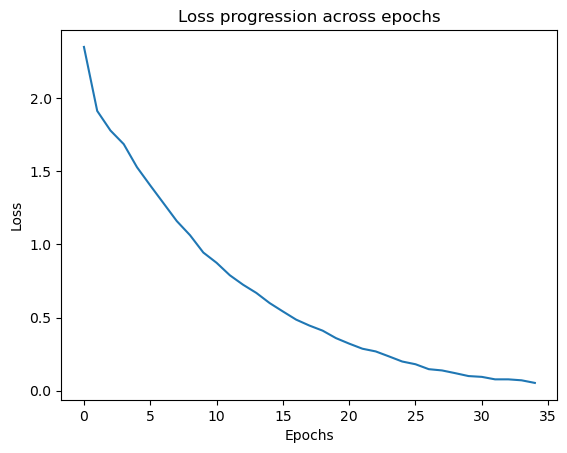

In [34]:

plot_loss(train_losses)

# predict with the trained model
predict(
    model,
    test_dataloader = test_dataloader,
    device = DEVICE
)


### Evaluated part: 

Now, we add skip connections. Notice that sometimes the skip connection cannot be simply an identity function, since the dimensions will not match. Identify the condition when this is necessary. In that case, the shortcut function should be a convolution followed by BatchNorm.

**Question** Fill the code below and train the network!

In [13]:
class CorrectBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        # YOUR CODE GOES HERE

        # 1. 保存输入数据，准备作为残差（捷径）
        # 注意：这里的 shortcut 已经在 __init__ 里定义好了，
        # 如果维度不匹配它会自动调整，如果匹配它就是空的（相当于直接传 x）
        residual = self.shortcut(x)

        # 2. 主路径（Main Path）：正常的卷积操作
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # 3. 核心步骤：将主路径的结果与捷径的结果相加
        out += residual 

        # 4. 最后再过一次 ReLU 激活函数
        out = F.relu(out)

        return out

`self.shortcut` 在这里的目的是确保残差连接（residual connection）中的输入 $x$ 和主路径（main path）经过卷积后的输出 `out` 具有相同的尺寸和通道数，从而能够进行逐元素相加。

**1. 为什么要使用 shortcut？**

ResNet 的核心思想是学习残差函数 $F(x) = H(x) - x$，最终输出为 $H(x) = F(x) + x$。这个 $+x$ 就是残差连接。然而，在卷积神经网络中，随着层数的增加，特征图的尺寸（高和宽）可能会因为 `stride > 1` 而减小，通道数（channel）也可能发生变化。

如果主路径上的卷积操作改变了特征图的尺寸或通道数，那么原始输入 $x$ 就无法直接与卷积后的输出 `out` 相加，因为它们的形状不匹配。

**2. `self.shortcut` 的逻辑**

`CorrectBlock` 中的 `__init__` 方法里对 `self.shortcut` 的定义如下：

```python
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
```

这段代码涵盖了两种情况：

  * **情况一：恒等映射 (Identity Mapping)**

      * **条件：** `stride == 1` 且 `in_planes == planes`。
      * **含义：** 主路径没有改变特征图的大小（步长为 1）也没有改变通道数（输入输出通道数相等）。
      * **操作：** `self.shortcut` 是一个空的 `nn.Sequential()`。在 `forward` 中调用 `self.shortcut(x)` 实际上就是直接返回 $x$ 本身。这时候残差连接就是简单的 $x$。

  * **情况二：投影映射 (Projection Mapping)**

      * **条件：** `stride != 1` 或 `in_planes != planes`。
      * **含义：** 主路径改变了特征图的大小（比如步长为 2 导致尺寸减半）或者改变了通道数（例如从 64 增加到 128）。
      * **操作：** 此时，不能直接把 $x$ 加到输出上。需要对 $x$ 进行变换，使其形状与主路径的输出一致。
          * `nn.Conv2d(..., kernel_size=1, stride=stride, ...)`：使用 $1 \times 1$ 卷积核。
              * 如果有 `stride`，它可以用来下采样，减小特征图的宽和高。
              * 它可以用来改变通道数，从 `in_planes` 变为 `planes`。
          * `nn.BatchNorm2d(planes)`：对变换后的 $x$ 进行归一化，以匹配主路径的分布。
      * 经过这个 `shortcut` 处理后，`residual` 的形状就和 `out` 一样了，可以进行相加。

**总结**

在 `forward` 函数中：

```python
        residual = self.shortcut(x)
```

这一行代码非常智能：

  * 如果不需要调整形状，`residual` 就是输入 `x` 原封不动。
  * 如果需要调整形状（因为下采样或通道数变化），`self.shortcut` 会自动通过 $1 \times 1$ 卷积将输入 `x` 转换成与 `out` 匹配的形状。

这保证了后续的 `out += residual` 操作始终是合法的，让网络能够顺利学习残差。

并不是每一层（每一个卷积层）都有 Shortcut。

准确地说：**每一个“残差块”（Residual Block）都有一个 Shortcut**。

以下是详细解释：

1.  **Shortcut 的跨度：**
    * 在一个标准的残差块（比如你的 `CorrectBlock`）中，通常包含 **2 层** 卷积（`conv1` 和 `conv2`）。
    * Shortcut 是连接这个 Block 的**输入**和这个 Block 的**最终输出**（在经过第 2 层卷积之后）。
    * 所以，Shortcut 是**跨越了 2 层卷积**，而不是每一层卷积都跨越。

2.  **整体结构：**
    * ResNet 是由很多个这样的 Block 堆叠起来的。
    * 信号在网络中的流动方式是：跳过 2 层 -> 相加 -> 再跳过 2 层 -> 相加...
    * 这就好比接力赛，不是每跑一步就交接一次棒，而是每跑一段距离（一个 Block）才进行一次信息的融合。

**总结：**
* **对于单独的卷积层：** 不是每一层都有（它是每隔两层有一个连接）。
* **对于 Block（积木）：** 是的，每一个 Block 都有 Shortcut（无论是恒等映射还是投影映射）。

Epoch 0: Train Loss=2.2148
Epoch 1: Train Loss=1.6065
Epoch 2: Train Loss=1.3834
Epoch 3: Train Loss=1.2231
Epoch 4: Train Loss=1.0596
Epoch 5: Train Loss=0.9323
Epoch 6: Train Loss=0.7857
Epoch 7: Train Loss=0.6776
Epoch 8: Train Loss=0.5752
Epoch 9: Train Loss=0.4809
Epoch 10: Train Loss=0.3727
Epoch 11: Train Loss=0.2702
Epoch 12: Train Loss=0.1997
Epoch 13: Train Loss=0.1470
Epoch 14: Train Loss=0.1056
Epoch 15: Train Loss=0.0804
Epoch 16: Train Loss=0.0592
Epoch 17: Train Loss=0.0573
Epoch 18: Train Loss=0.0467
Epoch 19: Train Loss=0.0401
Epoch 20: Train Loss=0.0431
Epoch 21: Train Loss=0.0405
Epoch 22: Train Loss=0.0365
Epoch 23: Train Loss=0.0240
Epoch 24: Train Loss=0.0223
Epoch 25: Train Loss=0.0207
Epoch 26: Train Loss=0.0178
Epoch 27: Train Loss=0.0237
Epoch 28: Train Loss=0.0256
Epoch 29: Train Loss=0.0246
Epoch 30: Train Loss=0.0243
Epoch 31: Train Loss=0.0228
Epoch 32: Train Loss=0.0161
Epoch 33: Train Loss=0.0158
Epoch 34: Train Loss=0.0151
Test set: Avg. loss: 1.4874, A

(1.4874197875976563, tensor(77.9000, device='cuda:0'))

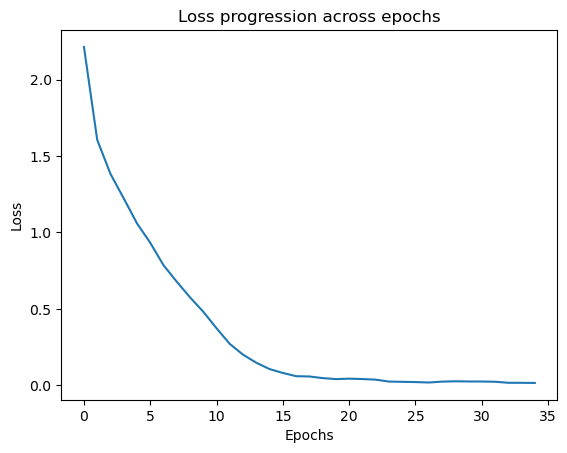

In [ ]:
# initialize the model
model = ResNet(block=CorrectBlock, num_blocks=[2,2,2,2]).to(DEVICE)

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# train the ResNet

train_losses, valid_losses, valid_accs =   fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        # epochs = 35,
        epochs = 60, # changed from 35 to 60， since data argumentation is used
        device = DEVICE
    )
plot_loss( train_losses )

# predict with the trained model
predict(
    model,
    test_dataloader = test_dataloader,
    device = DEVICE
)

**Question:** It looks like the model without the residual connections performs better (3-4%), but on a closer examination of the training curves the residual model achieves lower loss much faster and then plateaus. You might try to add a scheduler to boost the performance!

In [14]:
# Re-initialize the model to start fresh
model = ResNet(block=CorrectBlock, num_blocks=[2,2,2,2]).to(DEVICE)

# Define the optimizer (SGD with momentum is standard for ResNets)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# Define the Scheduler
# This will multiply the LR by 0.1 at epoch 15 and again at epoch 25
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, 
    milestones=[30, 50], 
    # milestones=[15, 25], 
    gamma=0.1
)

print("Model parameters: ", sum(p.numel() for p in model.parameters()))

Model parameters:  11173962


Epoch 0: Loss=2.5101453795724984
Epoch 1: Loss=1.8034935703082962
Epoch 2: Loss=1.606535792350769
Epoch 3: Loss=1.46858270314275
Epoch 4: Loss=1.3146464557063824
Epoch 5: Loss=1.165246202021229
Epoch 6: Loss=1.0304197085147002
Epoch 7: Loss=0.9300808699763551
Epoch 8: Loss=0.8341971562833203
Epoch 9: Loss=0.7623379084528709
Epoch 10: Loss=0.6908593469736527
Epoch 11: Loss=0.6262097529002598
Epoch 12: Loss=0.5807943380608851
Epoch 13: Loss=0.5325749741525067
Epoch 14: Loss=0.496820081253441
Epoch 15: Loss=0.45993170263815897
Epoch 16: Loss=0.41598869829761737
Epoch 17: Loss=0.4039642750000467
Epoch 18: Loss=0.3815789849174266
Epoch 19: Loss=0.3596467801502773
Epoch 20: Loss=0.3494576319139831
Epoch 21: Loss=0.32341176636364993
Epoch 22: Loss=0.30405253749720906
Epoch 23: Loss=0.29385895510109106
Epoch 24: Loss=0.27462493856342474
Epoch 25: Loss=0.26457119018447645
Epoch 26: Loss=0.2493985173653583
Epoch 27: Loss=0.23593410363002698
Epoch 28: Loss=0.21837806975354954
Epoch 29: Loss=0.212

(0.3077652862548828, tensor(91.3300, device='cuda:0'))

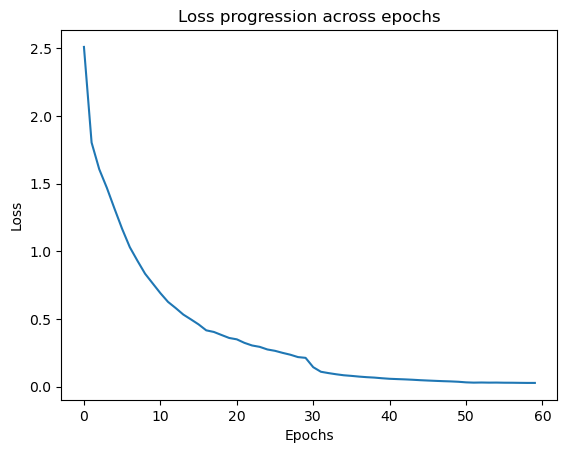

In [19]:
# Train using the fit_scheduler function
# Make sure to use fit_scheduler, not just fit, so the LR updates happen!
train_losses = fit_scheduler(
    model=model,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=60, # again, 60 epochs due to data augmentation
    device=DEVICE,
    scheduler=scheduler
)

plot_loss(train_losses)

predict(
    model,
    test_dataloader=test_dataloader,
    device=DEVICE
)